<a href="https://colab.research.google.com/github/Maverick29rus/homework/blob/master/%2218_%D0%A1%D0%B2%D0%B5%D1%80%D1%82%D0%BE%D1%87%D0%BD%D1%8B%D0%B5%20%D0%BD%D0%B5%D0%B9%D1%82%D1%80%D0%BE%D0%BD%D0%BD%D1%8B%D0%B5%20%D1%81%D0%B5%D1%82%D0%B8_(cats%20and%20dogs)%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Навигация по уроку**

1. [Введение в сверточные нейронные сети](https://colab.research.google.com/drive/10cBnEfHhZlv3ZhEgVimA3GqSEZtvqpTv)
2. [Обучение сверточной нейронной сети на ограниченном наборе данных](https://colab.research.google.com/drive/1e1aZ9K1vQIujPf1mzmta5xtbfNqJ_ai-)
3. [Предобученные сверточные НС](https://colab.research.google.com/drive/12VehrJe062P9QImtvjILQG0DOLooiyk0)
4. Домашняя работа

В данном домашнем задании вам необходимо:

1. Используйте датасет "Собаки и кошки", рассмотренный в данном уроке. Причем используйте его целиком, а не только 4000 изображений.
2. Проведите аугментацию изображений.
3. В качестве предобученной модели возьмите `MobileNet`
4. Создайте модель, приведенную ниже.
5. Обучите модель и проверьте на тестовой выборке.
6. Если модель не обеспечивает заданную точность - "поиграйтесь" с гиперпараметрами.


Для получения 3 баллов за задание необходимо достичь на контрольной выборке точности 90%, 4 баллов -  более 93%, 5 баллов - более 95%.

На 20 тыс. изображений данная модель выдавала нам результат 99%.

**Подсказка**. Обратите внимание, что предлагаемая модель уже не является бинарной классификацией. Это уже задача многоклассовой классификации (в нашем случае 2 класса). А значит в генераторах изображений необходимо использовать:

```pyton
class_mode='categorical'
```

Также необходимо вспомнить какую функцию ошибки использовать с задачей многоклассовой классификации. Можно попробовать в качестве оптимизатора использовать Adam с разными шагами.

Также обратите внимание, что вместо слоя `Flatten()`, вам предлагается использовать `GlobalAveragePooling2D()` (https://keras.io/api/layers/pooling_layers/global_average_pooling2d/).


In [ ]:
import os
# Набор утилит для работы с файловой системой
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import models, optimizers, Model
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from keras.applications import MobileNet
import matplotlib.pyplot as plt
import random
import numpy as np
import tensorflow as tf
from keras.backend import clear_session


In [ ]:
# @title Загрузка набора данных

!wget https://storage.yandexcloud.net/academy.ai/cat-and-dog.zip
# Разархивируем датасета во временную папку 'temp'
!unzip -qo "cat-and-dog" -d ./temp


--2025-04-03 07:12:13--  https://storage.yandexcloud.net/academy.ai/cat-and-dog.zip
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228082266 (218M) [application/x-zip-compressed]
Saving to: ‘cat-and-dog.zip’

cat-and-dog.zip     100%[===================>] 217.52M  20.2MB/s    in 12s     

2025-04-03 07:12:25 (18.1 MB/s) - ‘cat-and-dog.zip’ saved [228082266/228082266]



In [ ]:
[x[0] for x in os.walk('./temp')]

['./temp',
 './temp/training_set',
 './temp/training_set/training_set',
 './temp/training_set/training_set/cats',
 './temp/training_set/training_set/dogs',
 './temp/test_set',
 './temp/test_set/test_set',
 './temp/test_set/test_set/cats',
 './temp/test_set/test_set/dogs']

In [ ]:
# Папка с папками картинок, рассортированных по категориям
TRAIN_PATH = './temp/training_set/training_set/'
TEST_PATH = './temp/test_set/test_set/'

# Папка в которой будем создавать выборки
BASE_DIR = './dataset/'

# Определение списка имен классов
CLASS_LIST = sorted(os.listdir(TRAIN_PATH))

# Определение количества классов
CLASS_COUNT = len(CLASS_LIST)

# При повторном запуске пересоздаим структуру каталогов
# Если папка существует, то удаляем ее со всеми вложенными каталогами и файлами
if os.path.exists(BASE_DIR):
    shutil.rmtree(BASE_DIR)

# Создаем папку по пути BASE_DIR
os.mkdir(BASE_DIR)

# Сцепляем путь до папки с именем вложенной папки. Аналогично BASE_DIR + '/train'
train_dir = os.path.join(BASE_DIR, 'train')

# Создаем подпапку, используя путь
os.mkdir(train_dir)

# Сцепляем путь до папки с именем вложенной папки. Аналогично BASE_DIR + '/validation'
val_dir = os.path.join(BASE_DIR, 'validation')

# Создаем подпапку, используя путь
os.mkdir(val_dir)

# Сцепляем путь до папки с именем вложенной папки. Аналогично BASE_DIR + '/test'
test_dir = os.path.join(BASE_DIR, 'test')

# Создаем подпапку, используя путь
os.mkdir(test_dir)

# Функция создания подвыборок (папок с файлами)
def create_dataset(
    img_path: str,         # Путь к файлам с изображениями классов
    new_path: str,         # Путь к папке с выборками
    class_name: str,       # Имя класса (оно же и имя папки)
    start_index: int,      # Стартовый индекс изображения, с которого начинаем подвыборку
    end_index: int         # Конечный индекс изображения, до которого создаем подвыборку

):

    src_path = os.path.join(img_path, class_name)  # Полный путь к папке с изображениями класса
    dst_path = os.path.join(new_path, class_name)  # Полный путь к папке с новым датасетом класса

    # Получение списка имен файлов с изображениями текущего класса
    class_files = os.listdir(src_path)

    # Создаем подпапку, используя путь
    os.mkdir(dst_path)

    # Перебираем элементы, отобранного списка с начального по конечный индекс
    for fname in class_files[start_index : end_index]:
        # Путь к файлу (источник)
        src = os.path.join(src_path, fname)
        # Новый путь расположения файла (назначение)
        dst = os.path.join(dst_path, fname)
        # Копируем файл из источника в новое место (назначение)
        shutil.copyfile(src, dst)

data_files = []  # Cписок путей к файлам изображений
data_labels = [] # Список меток классов для обучения
test_labels = [] # Список меток классов для проверки

for class_label in range(CLASS_COUNT):    # Перебор по всем классам по порядку номеров (их меток)
    class_name = CLASS_LIST[class_label]  # Выборка имени класса из списка имен

    train_path = TRAIN_PATH + class_name  # Полный путь к папке с изображениями класса
    # Получение списка имен файлов с изображениями текущего класса
    train_files = os.listdir(train_path)
    # Вывод информации о численности класса
    print(f'Размер класса {class_name} составляет {len(train_files)} животных в тренировочной выборке')

    test_path = TEST_PATH + class_name  # Полный путь к папке с изображениями класса
    # Получение списка имен файлов с изображениями текущего класса
    test_files = os.listdir(test_path)
    # Вывод информации о численности класса
    print(f'Размер класса {class_name} составляет {len(test_files)} животных в тестовой выборке')

    # Добавление к общему списку всех файлов класса с добавлением родительского пути
    #data_files += [f'{train_path}/{file_name}' for file_name in train_files]

    # Добавление к общему списку меток текущего класса - их ровно столько, сколько файлов в классе
    data_labels += [class_label] * len(train_files)

    print('Общий размер базы для обучения:', len(data_labels))

    # Добавление к общему списку меток текущего класса - их ровно столько, сколько файлов в классе
    test_labels += [class_label] * len(test_files)

    print('Общий размер базы для проверки:', len(test_labels))

    num_train_files = round(len(train_files) * 0.8) # Выбираем размер обучающей выборки равный 80 % от всех данных

    # Создаем обучающую выборку для заданного класса
    create_dataset(TRAIN_PATH, train_dir, class_name, 0, num_train_files)
    # Создаем проверочную выборку для заданного класса
    create_dataset(TRAIN_PATH, val_dir, class_name, num_train_files, len(train_files ))
    # Создаем тестовую выборку для заданного класса
    create_dataset(TEST_PATH, test_dir, class_name, 0, len(test_files ))

print('Число кошек %s, число собак %s в обучающей выборке' \
      % (
          len(os.listdir(os.path.join(train_dir, 'cats'))),
          len(os.listdir(os.path.join(train_dir, 'dogs')))
         )
      )

print('Число кошек %s, число собак %s в проверочной выборке' \
      % (
          len(os.listdir(os.path.join(val_dir, 'cats'))),
          len(os.listdir(os.path.join(val_dir, 'dogs')))
         )
      )

print('Число кошек %s, число собак %s в контрольной выборке' \
      % (
          len(os.listdir(os.path.join(test_dir, 'cats'))),
          len(os.listdir(os.path.join(test_dir, 'dogs')))
         )
      )


Размер класса cats составляет 4000 животных в тренировочной выборке
Размер класса cats составляет 1011 животных в тестовой выборке
Общий размер базы для обучения: 4000
Общий размер базы для проверки: 1011
Размер класса dogs составляет 4005 животных в тренировочной выборке
Размер класса dogs составляет 1012 животных в тестовой выборке
Общий размер базы для обучения: 8005
Общий размер базы для проверки: 2023
Число кошек 3200, число собак 3204 в обучающей выборке
Число кошек 800, число собак 801 в проверочной выборке
Число кошек 1011, число собак 1012 в контрольной выборке


In [ ]:
# генератор для обучающей выборки
train_datagen = ImageDataGenerator(
    rescale=1./255,           # нормализация данных
    rotation_range=40,        # поворот 40 градусов
    width_shift_range=0.2,    # смещенние изображения по горизонтали
    height_shift_range=0.2,   # смещенние изображения по вертикали
    shear_range=0.2,          # случайный сдвиг
    zoom_range=0.2,           # случайное масштабирование
    horizontal_flip=True,     # отражение по горизонтали
    fill_mode='nearest'       # стратегия заполнения пустых пикселей при трансформации
)
# генератор для проверочной выборки
test_datagen = ImageDataGenerator(rescale=1./255)

# генерация картинок из папки для обучающей выборки
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='categorical'
)

# генерация картинок из папки для проверочной выборки
validation_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='categorical'
)

Found 6404 images belonging to 2 classes.
Found 1601 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.


In [ ]:
def model_maker():
    base_model = MobileNet(include_top=False, input_shape = (150, 150, 3))
    base_model.summary()

    for layer in base_model.layers[:]:
        layer.trainable = False

    input = Input(shape=(150, 150, 3))
    custom_model = base_model(input)
    custom_model = GlobalAveragePooling2D()(custom_model)
    custom_model = Dense(64, activation='relu')(custom_model)
    custom_model = Dropout(0.5)(custom_model)
    predictions = Dense(CLASS_COUNT, activation='softmax')(custom_model)

    return Model(inputs=input, outputs=predictions)

In [ ]:
def clear_model(seed_value=0):
    ''' Функция очищает модель и задает random seed для лучшей воспроизводимости результатов модели '''

    clear_session()
    # 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
    os.environ['PYTHONHASHSEED']=str(seed_value)
    # 2. Set the `python` built-in pseudo-random generator at a fixed value
    random.seed(seed_value)
    # 3. Set the `numpy` pseudo-random generator at a fixed value
    np.random.seed(seed_value)
    # 4. Set the `tensorflow` pseudo-random generator at a fixed value
    tf.config.experimental.enable_op_determinism()
    tf.random.set_seed(seed_value)

In [ ]:
# Рисуем графики
def show_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'r', label='Точность на обучающей выборке')
    plt.plot(epochs, val_acc, 'bo', label='Точность на проверочной выборке')
    plt.title('График точности на проверочной и обучающей выборках')
    plt.legend()

    plt.figure()
    plt.plot(epochs, loss, 'r', label='Потери на обучающей выборке')
    plt.plot(epochs, val_loss, 'bo', label='Потери на проверочной выборке')
    plt.title('График потерь на проверочной и обучающей выборках')
    plt.legend()
    plt.show()

In [ ]:
clear_model()
model = model_maker()
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(
                              #learning_rate=1e-5
                              ),
    metrics=['acc']
)
model.summary()

<ipython-input-7-6ddc2bec527d>:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(include_top=False, input_shape = (150, 150, 3))


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "mobilenet_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 75, 75, 32)          │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 75, 75, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 75, 75, 32)          │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 75, 75, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 75, 75, 64)          │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 75, 75, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 76, 76, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 37, 37, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 37, 37, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 37, 37, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 37, 37, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 37, 37, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 37, 37, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 37, 37, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 37, 37, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,228,864 (12.32 MB)

 Trainable params: 3,206,976 (12.23 MB)

 Non-trainable params: 21,888 (85.50 KB)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenet_1.00_224 (Functional)      │ (None, 4, 4, 1024)          │       3,228,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          65,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,294,594 (12.57 MB)

 Trainable params: 65,730 (256.76 KB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [ ]:
# Обучаем модель
history = model.fit(
    train_generator,
    epochs=3,
    validation_data=validation_generator
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
321/321 ━━━━━━━━━━━━━━━━━━━━ 200s 610ms/step - acc: 0.8532 - loss: 0.3849 - val_acc: 0.9650 - val_loss: 0.0933
Epoch 2/3
321/321 ━━━━━━━━━━━━━━━━━━━━ 198s 597ms/step - acc: 0.9303 - loss: 0.1752 - val_acc: 0.9588 - val_loss: 0.1119
Epoch 3/3
321/321 ━━━━━━━━━━━━━━━━━━━━ 201s 595ms/step - acc: 0.9350 - loss: 0.1605 - val_acc: 0.9656 - val_loss: 0.1031


In [ ]:
model.save('cats_and_dogs_model.h5') # сохраняем модель

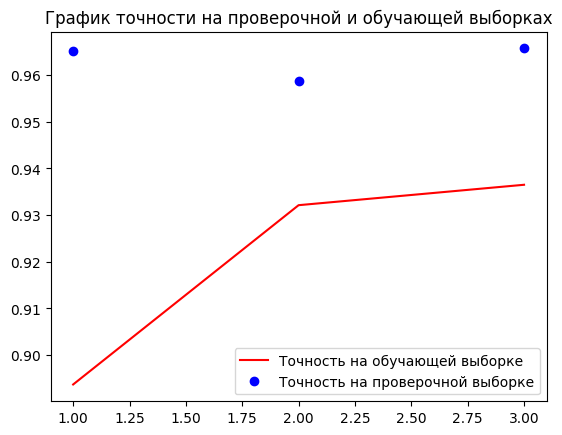

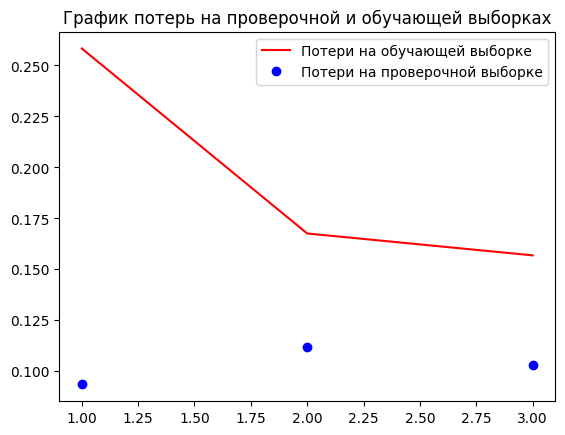

In [ ]:
show_history(history)

In [ ]:
test_loss, test_acc = model.evaluate(test_generator, steps=50)
print('Точность на Kонтрольной выборке:', round(test_acc * 100, 2), '%')

50/50 ━━━━━━━━━━━━━━━━━━━━ 16s 324ms/step - acc: 0.9692 - loss: 0.0943
Точность на Kонтрольной выборке: 96.8 %
